In [2]:
import skvideo.io
import skimage.io
from skimage import color,exposure,transform,filters
import skvideo.datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import sklearn

#### function:frameCountError

In [3]:
def frameCountError(reader,n):
    # get total number of frames in the video
    T = reader.getShape()[0]
    # give error if n>T
    if n>T:
        reader.close()
        raise ValueError("n should be less than or equal to %i, the total number frames in the video"%T)

#### function:getName

In [4]:
def getName(variable):
    for k,v in list(globals().items()):
        if v is variable:
            return k

# Algorithm 3
![](lgo3.svg)

This comparison involves both temporal and spacial factors. This is a one way we can merge Algo1 and Algo2.

Load the video paths

In [5]:
adPath = "D:/Ads/seperate trims/"
ads = [adPath+"ADD_%i.mp4"%i for i in range(1,9,1)]            # ads small size
g_ads = ["g_ad_%i.mp4"%i for i in range(1,9,1)]                # Gamma-corrected ads

vidPath = "D:/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/"
vids = [vidPath+"ad%i.mp4"%i for i in range(1,9,1)]            # ads original size
nVids = ["nVid%i.mp4"%i for i in range(1,9,1)]                 # sigma = 5
nVids2 = ["nVid2_%i.mp4"%i for i in range(1,9,1)]              # sigma = 20
nVids3 = ["nVids3_%i.mp4"%i for i in range(1,9,1)]             # sigma = 1

We use `tf2` here.

In [6]:
tf2 = lambda frame: np.transpose(np.rot90(frame))

`getChange` function will do the same as in the last 2 algorithms, except for it will take "`Frame i`" and "`Frame i+1`" as the inputs but it will give change between `rFrame` of "`Frame i`" and "`Frame i+1`"

In [7]:
def getChangeTf(frame1,frame2,plane,tf):
    """
        this gives 3 outputs regarding the specified plane of rFrame and frame
        inc: 
        dec:
        incdec:
    """
    frame1 = frame1[:,:,plane]
    frame2 = frame2[:,:,plane]
    
    # this is the transformation done:
    rFrame = tf(frame1)
    
    inc = (rFrame>frame2)
    dec =  (rFrame<frame2)
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

In [8]:
getChange = lambda frame1, frame2, plane: getChangeTf(frame1,frame2,plane,tf2)

`getMatchScore` function will now have to cater for 2 frames  2 videos. In addition we'll make the function more flexible by adding another parameter `k` which is the frame gap between 2 frames that is compared.

#### function: getMatchScoreExtended

In [9]:
def getMatchScoreExtended(vid1,vid2,n,k):
    """give score using first n frames
    """
    reader1 = skvideo.io.FFmpegReader(vid1)
    reader2 = skvideo.io.FFmpegReader(vid2)
    frameCountError(reader1,n+1)
    frameCountError(reader2,n+1)
    out = 0
    for i in range(n):
        frame1Vid1, frame1Vid2 = reader1._readFrame(),reader2._readFrame()
        for j in range(k):
            frame2Vid1,frame2Vid2 = reader1._readFrame(),reader2._readFrame()
        inc1,dec1,incdec1 = getChange(frame1Vid1,frame2Vid1,1)
        inc2,dec2,incdec2 = getChange(frame1Vid2,frame2Vid2,1)
        interestPoints = np.logical_and(incdec1,incdec2)
        cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
        incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
        incScore = np.sum(incScoreMat)
        sumInterest = np.sum(interestPoints)
        if incScore:
            out += (sumInterest/(incScore))
    reader1.close()
    reader2.close()
    return out    

#### stats

In [10]:
def stats(data):
    """gives mean and standard deviation of data"""
    mean_data = np.sum(data)/data.size
    std_dev_data = np.sqrt(np.sum((data-mean_data)**2)/data.size)
    return np.array((mean_data,std_dev_data))

#### function:getMatchness

In [11]:
def getMatchness(matchFunc,list1,list2,n,k):
    """This function says how good the matchFunc is."""
    l = []
    for i in range(len(list2)):
        m = []
        for j in range(len(list1)):
            score = matchFunc(list1[j],list2[i],n,k)
            m.append(score)
        l.append(m)
    l = np.array(l)
    diag = l.diagonal()
    mean_diag,std_dev_diag = stats(diag)
    cv_diag = std_dev_diag/mean_diag
    eye = ~np.eye(l.shape[0],dtype=bool)
    ndiag = eye*l
    mean_ndiag = np.sum(ndiag)/np.sum(eye)
    mean_ndiag_MAT = eye*mean_ndiag
    std_dev_ndiag = np.sqrt(np.sum((ndiag-mean_ndiag)**2)/np.sum(eye))
    cv_ndiag = std_dev_ndiag/mean_ndiag
    print("diagonal mean = {0} \t sd = {1} CV = {2}".format(mean_diag,
                                                std_dev_diag,cv_diag))
    print("ndiag mean = {0} \t sd = {1} CV = {2}".format(mean_ndiag,
                                            std_dev_ndiag,cv_ndiag))
    heatmap = plt.imshow(l, cmap='hot', interpolation='nearest')
    plt.xlabel("%s"%getName(list1))
    plt.ylabel("%s"%getName(list2))
    plt.colorbar(heatmap)
    plt.show()
    return mean_diag, std_dev_diag, cv_diag,mean_ndiag,std_dev_ndiag,cv_ndiag

### Check the algo

diagonal mean = 46.10904900414798 	 sd = 21.04879464934806 CV = 0.4565002988340642
ndiag mean = 2.128984620794339 	 sd = 0.9044409543715312 CV = 0.4248226809802308


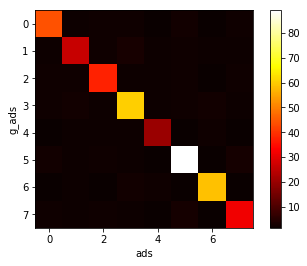

(46.109049004147977,
 21.048794649348061,
 0.45650029883406418,
 2.128984620794339,
 0.90444095437153116,
 0.42482268098023079)

In [22]:
getMatchness(getMatchScoreExtended,ads,g_ads,1,1)

The `CV` values clearly depicts how good this algo is. This is achieved with the small overhead of capturing next frame.

In [12]:
def getStats(matchFunc,list1,list2,n,k):
    """This function says how good the matchFunc is over video lists list1 and list2
        using n frames.
    ."""
    l = []
    for i in range(len(list2)):
        m = []
        for j in range(len(list1)):
            score = matchFunc(list1[j],list2[i],n,k)
            m.append(score)
        l.append(m)
    l = np.array(l)
    diag = l.diagonal()
    mean_diag,std_dev_diag = stats(diag)
    cv_diag = std_dev_diag/mean_diag
    eye = ~np.eye(l.shape[0],dtype=bool)
    ndiag = eye*l
    mean_ndiag = np.sum(ndiag)/np.sum(eye)
    mean_ndiag_MAT = eye*mean_ndiag
    std_dev_ndiag = np.sqrt(np.sum((ndiag-mean_ndiag)**2)/np.sum(eye))
    cv_ndiag = std_dev_ndiag/mean_ndiag
    return mean_diag, std_dev_diag, cv_diag,mean_ndiag,std_dev_ndiag,cv_ndiag

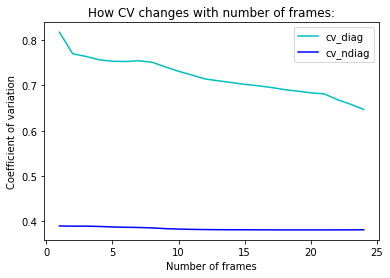

In [15]:
l = []
frameCount = []
for i in range(1,25,1):
    frameCount.append(i)
    s = getStats(getMatchScoreExtended,vids,nVids,i,1)
    l.append(s)
l = np.array(l).T
plt.plot(frameCount,l[2],'c',label='cv_diag')
plt.plot(frameCount,l[5],'b',label='cv_ndiag')
plt.legend(loc = "best")
plt.title("How CV changes with number of frames:")
plt.xlabel("Number of frames")
plt.ylabel("Coefficient of variation")
plt.show()

The idea of coefficient of variance may be vague, so a more practical way of looking at data will be observing the minimum and maximum values of the scores of diagonal elements and non diagonal elements of the `l` matrix which is the output of the [`getMatchness`](#getMatchness) function. Let's define a new function to get those statistics.

#### function: getStats2

In [13]:
def getStats2(matchFunc, list1,list2,n,k):
    """returns min & max of diags and ndiags and plots it."""
    l = []
    for i in range(len(list2)):
        m = []
        for j in range(len(list1)):
            score = matchFunc(list1[j],list2[i],n,k)
            m.append(score)
        l.append(m)
    l = np.array(l)
    
    diag = l.diagonal()
    ndiags = [l[i,j] for i in range(l.shape[0]) for j in range(l.shape[1]) if i!=j]
    
    return min(diag),max(diag),min(ndiags),max(ndiags)   

Let's see how those statistics change with respect to number of frames for `ads` and `g_ads`

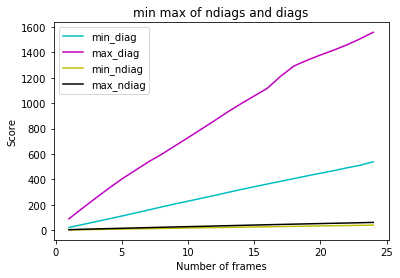

In [57]:
l = []
frameCount = []
for i in range(1,25,1):
    frameCount.append(i)
    s = getStats2(getMatchScoreExtended,ads,g_ads,i,1)
    l.append(s)
l = np.array(l).T
plt.plot(frameCount,l[0],'c',label='min_diag')
plt.plot(frameCount,l[1],'m',label='max_diag')
plt.plot(frameCount,l[2],'y',label='min_ndiag')
plt.plot(frameCount,l[3],'k',label='max_ndiag')
plt.legend(loc = "best")
plt.title("min max of ndiags and diags")
plt.xlabel("Number of frames")
plt.ylabel("Score")
plt.show()

Since what we are interested in are `min_diag` and `max_ndiag` let's have a close look at them.

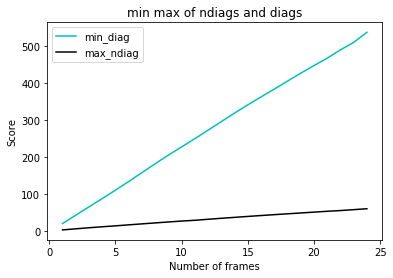

In [58]:
plt.plot(frameCount,l[0],'c',label='min_diag')
plt.plot(frameCount,l[3],'k',label='max_ndiag')
plt.legend(loc = "best")
plt.title("min max of ndiags and diags")
plt.xlabel("Number of frames")
plt.ylabel("Score")
plt.show()

We can see a clear seperation between the 2 sets. In addition the seperation increases when number of frames considered is increased which is exactly what we expect.

Although this looks fine for gamma correction, this may not be the case for noise-corrupted videos. Let's take the specimen `nVids` for which noise behaves $\cal{N}(0,5)$ and compare it with `vids.`

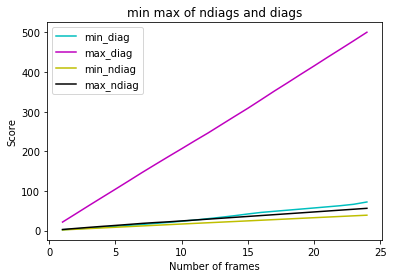

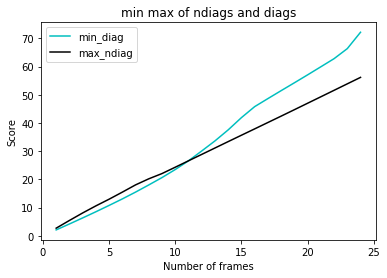

In [59]:
l = []
frameCount = []
for i in range(1,25,1):
    frameCount.append(i)
    s = getStats2(getMatchScoreExtended,vids,nVids,i,1)
    l.append(s)
l = np.array(l).T
plt.plot(frameCount,l[0],'c',label='min_diag')
plt.plot(frameCount,l[1],'m',label='max_diag')
plt.plot(frameCount,l[2],'y',label='min_ndiag')
plt.plot(frameCount,l[3],'k',label='max_ndiag')
plt.legend(loc = "best")
plt.title("min max of ndiags and diags")
plt.xlabel("Number of frames")
plt.ylabel("Score")
plt.show()

# closer look
plt.plot(frameCount,l[0],'c',label='min_diag')
plt.plot(frameCount,l[3],'k',label='max_ndiag')
plt.legend(loc = "best")
plt.title("min max of ndiags and diags")
plt.xlabel("Number of frames")
plt.ylabel("Score")
plt.show()

From the above plot it's clear that, at least 14 frames should be considered to get an absolute seperation between `diags` and `ndiags`.

Absolute seperation is not necessary in detecting the video. (Absolute seperation: `min_diag`>`max_diag`)

> For instance, to identify `ads[0]` when played `g_ads[0]` the maximum of upper most row should be in `(0,0)`. (_see_ [here](#Check-the-algo)). So there's no need to think of the global `min_diag` and `max_ndiag`. 



**Definition: Hit**/**Miss** Let the number of videos of interest (i.e. ads) be $n,$ $i\le n$. If $\max\left(l[i]\right)=l[i][i]$, it's a hit. Otherwise a miss. Here `l` is the [`matchness`](#function:getMatchness) matrix.


**Definition: Hit Ratio** $$\tt Hit\ Ratio:= \frac{Hits}{Hits+Misses}$$

Define a function to get that once given `l`.

In [14]:
def getHitRatio(l):
    """l is always a n x n matrix"""
    hits = 0
    N = l.shape[0]
    for i in range(N):
        if l[i][i]==max(l[i]):
            hits += 1
    return hits/N

#### function:get_l
This function will return the matchness matrix

In [16]:
def get_l(matchFunc,list1,list2,n,k):
    """This function outputs matchness matrix."""
    l = []
    for i in range(len(list2)):
        m = []
        for j in range(len(list1)):
            score = matchFunc(list1[j],list2[i],n,k)
            m.append(score)
        l.append(m)
    l = np.array(l)
    return l

Now let's see how hit ratio changes with other parameters.